
# Star clustering

Задачи:
1. EDA: распределения, корреляции, нормализация, отсечение выбросов, PCA.
2. Кластеризация: k-means, аггломеративная, DBSCAN, GMM.
3. Подбор числа кластеров по силуэту.
4. Сравнение с истинными метками (ARI, V-measure).
5. Подгруппа ярких объектов.


In [10]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score, v_measure_score
from sklearn.neighbors import NearestNeighbors

sns.set(style="whitegrid", context="notebook")


In [11]:

path = Path("star_classification.csv")
assert path.exists(), "CSV не найден"
df = pd.read_csv(path)
print(df.shape)
df.head()


(100000, 18)


,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [12]:

print(df['class'].value_counts())


class
GALAXY    59445
STAR      21594
QSO       18961
Name: count, dtype: int64


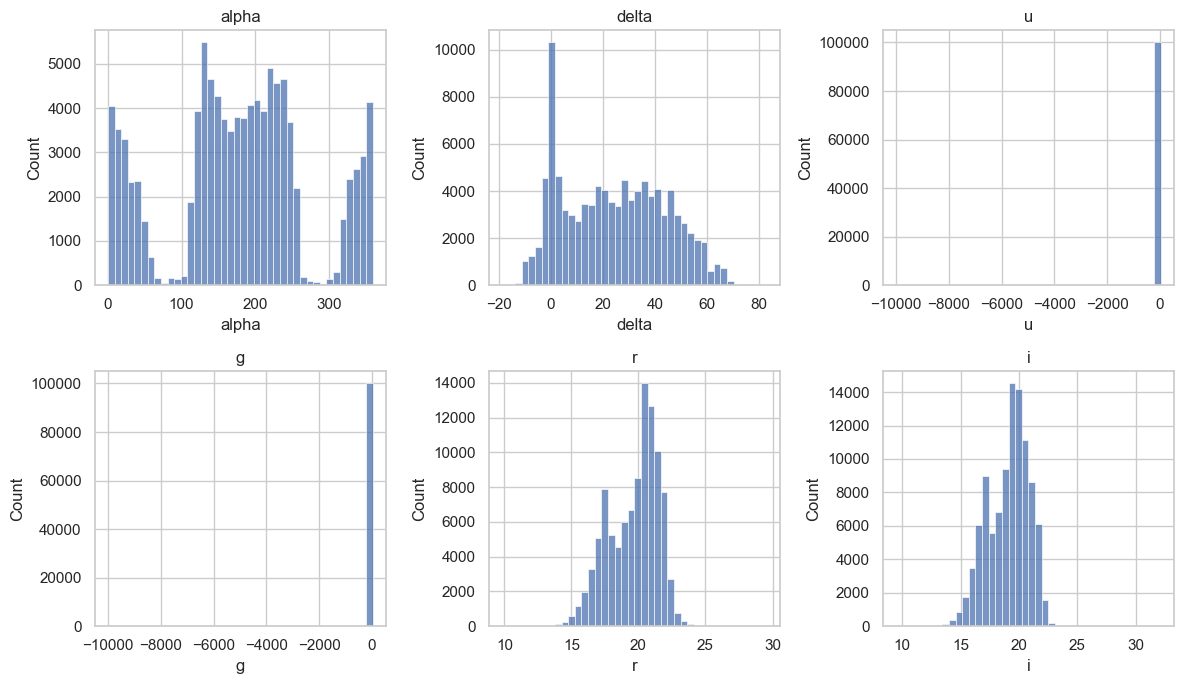

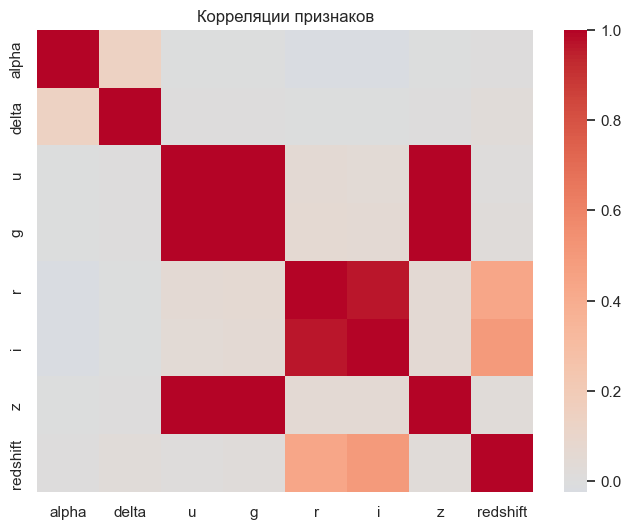

In [13]:

# Числовые признаки без id и метки
id_cols = ['obj_ID','run_ID','rerun_ID','cam_col','field_ID','spec_obj_ID','plate','MJD','fiber_ID']
feature_cols = [c for c in df.columns if c not in id_cols + ['class']]
X_raw = df[feature_cols]

fig, axes = plt.subplots(2, 3, figsize=(12, 7))
for ax, col in zip(axes.flat, feature_cols[:6]):
    sns.histplot(df[col], bins=40, ax=ax, kde=False)
    ax.set_title(col)
plt.tight_layout()
plt.show()

corr = X_raw.corr(numeric_only=True)
plt.figure(figsize=(8,6))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Корреляции признаков")
plt.show()


Explained variance (5 comps): 0.985844361573519


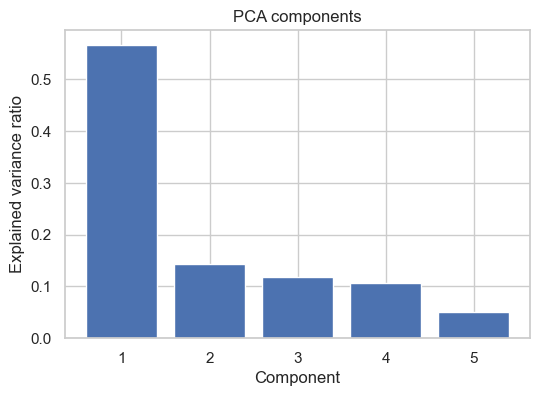

In [14]:

# Отсечение выбросов и стандартизация
lower = X_raw.quantile(0.01)
upper = X_raw.quantile(0.99)
X_clipped = X_raw.clip(lower, upper, axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clipped)

# PCA
pca = PCA(n_components=5, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print("Explained variance (5 comps):", pca.explained_variance_ratio_.sum())
plt.figure(figsize=(6,4))
plt.bar(range(1, 6), pca.explained_variance_ratio_)
plt.xlabel("Component")
plt.ylabel("Explained variance ratio")
plt.title("PCA components")
plt.show()


In [ ]:

#возьмем случайную подвыборку
sample_size = 20000
rng = np.random.default_rng(42)
sample_idx = rng.choice(len(df), size=sample_size, replace=False)
X_sample = X_pca[sample_idx]
y_sample = df['class'].iloc[sample_idx]


In [ ]:

results = []
for k in range(2, 7):
    km = KMeans(n_clusters=k, n_init=10, random_state=42).fit(X_sample)
    labels = km.labels_
    results.append(("kmeans", k, silhouette_score(X_sample, labels),
                    adjusted_rand_score(y_sample, labels),
                    v_measure_score(y_sample, labels)))

    gmm = GaussianMixture(n_components=k, random_state=42).fit(X_sample)
    lab_gmm = gmm.predict(X_sample)
    results.append(("gmm", k, silhouette_score(X_sample, lab_gmm),
                    adjusted_rand_score(y_sample, lab_gmm),
                    v_measure_score(y_sample, lab_gmm)))

for k in range(2, 6):
    agg = AgglomerativeClustering(n_clusters=k, linkage='ward').fit(X_sample)
    lab = agg.labels_
    results.append(("agg", k, silhouette_score(X_sample, lab),
                    adjusted_rand_score(y_sample, lab),
                    v_measure_score(y_sample, lab)))

# DBSCAN eps
subset = X_sample[:5000]
neigh = NearestNeighbors(n_neighbors=5).fit(subset)
dists, _ = neigh.kneighbors(subset)
k_dist = np.sort(dists[:, -1])
for eps in [np.percentile(k_dist, p) for p in (90, 95, 98)]:
    db = DBSCAN(eps=float(eps), min_samples=10).fit(X_sample)
    labels = db.labels_
    if len(set(labels)) <= 1 or (labels == -1).all():
        continue
    results.append((f"dbscan eps={eps:.3f}", len(set(labels)) - ( -1 in labels),
                    silhouette_score(X_sample, labels),
                    adjusted_rand_score(y_sample, labels),
                    v_measure_score(y_sample, labels)))

# Таблица результатов
res_df = pd.DataFrame(results, columns=["algo", "k", "silhouette", "ARI", "V"])
display(res_df.sort_values("silhouette", ascending=False).reset_index(drop=True))


,algo,k,silhouette,ARI,V
0,kmeans,2,0.389550,0.030374,0.069440
1,agg,2,0.378184,0.033449,0.089939
2,gmm,2,0.363856,0.026951,0.106939
3,kmeans,3,0.315575,0.266944,0.319122
4,kmeans,4,0.290548,0.171490,0.248909
5,kmeans,5,0.289118,0.118886,0.206736
6,agg,4,0.275681,0.157637,0.216669
7,agg,3,0.255509,0.033912,0.075821
8,agg,5,0.254109,0.109732,0.194505
9,dbscan eps=0.995,1,0.241625,0.003232,0.004199


In [17]:

# Кросс-таблица для kmeans k=3
km3 = KMeans(n_clusters=3, n_init=10, random_state=42).fit(X_sample)
lab3 = km3.labels_
ct = pd.crosstab(pd.Series(lab3, name='cluster'), pd.Series(y_sample, name='class'))
print(ct)


class    GALAXY  QSO  STAR
cluster                   
0           759  244   297
1          1249  430   483
2           360  117   100


In [18]:

# Подгруппа: яркие объекты g < 19
bright_mask = df['g'] < 19
bright_idx = np.where(bright_mask)[0]
bright_sample = rng.choice(bright_idx, size=min(12000, len(bright_idx)), replace=False)
X_bright = X_pca[bright_sample]
y_bright = df['class'].iloc[bright_sample]

km_b = KMeans(n_clusters=3, n_init=10, random_state=42).fit(X_bright)
lab_b = km_b.labels_
print('Bright subset size:', len(bright_sample))
print('silhouette', silhouette_score(X_bright, lab_b))
print('ARI', adjusted_rand_score(y_bright, lab_b))
print('V-measure', v_measure_score(y_bright, lab_b))
print(pd.crosstab(pd.Series(lab_b, name='cluster'), pd.Series(y_bright, name='class')))


Bright subset size: 12000
silhouette 0.24615485002167506
ARI 0.004863784315997418
V-measure 0.00936244562527418
class    GALAXY  QSO  STAR
cluster                   
0           211   10    95
1           318   26   173
2           349   24   185
